# Statement
For this project, we will perform several machine learning tasks for the Sure Tomorrow insurance company.  We will
1.  Find customers that are similar to a given customer, to help the company's agents with marketing.
2.  Develop a machine learning model to predict whether a customer is likely to receive an insurance benefit.
3.  Develop a linear regression model to predict the number of insurance benefits a customer is likely to receive.
4.  Demonstrate the feasibility of a data masking algorithm to protect customers' personal information. 

# Data Preprocessing & Exploration
In this section, we will take an initial look at the data, take care of any preprocessing requirements, and create a set of pairplots to see how features of the data relate to each other.

## Initialization

In [1]:
pip install -U scikit-learn

     |████████████████████████████████| 8.6 MB 7.1 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imbalanced-learn

     |████████████████████████████████| 199 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from imblearn.over_sampling import RandomOverSampler
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler

import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
RANDOM_STATE = 54321

## Preliminary data review

In [5]:
try:
    df = pd.read_csv('/datasets/insurance_us.csv')
except:
    df = pd.read_csv('insurance_us.csv')

In [6]:
df.sample(5)

,Gender,Age,Salary,Family members,Insurance benefits
4305,1,41.0,46500.0,1,0
296,1,26.0,40600.0,4,0
731,1,19.0,35600.0,2,0
302,0,29.0,42500.0,1,0
4328,1,35.0,47000.0,2,0


In [7]:
# Rename the colums to make the code look more consistent with its style.
df = df.rename(columns={'Gender': 'gender', 
                        'Age': 'age', 
                        'Salary': 'income', 
                        'Family members': 'family_members', 
                        'Insurance benefits': 'insurance_benefits'})

In [8]:
# Convert age column from float to int
df['age'] =  df['age'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# Review the descriptive statistics
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


### Conclusion (preliminary data review)
- There are no obvious missing values.
- We converted the <code>age</code> column from <code>float</code> to <code>int</code>.  Data types are appropriate.
- The similarity between the mean and median values for <code>age</code> and <code>income</code> suggests that outliers may not be a major factor.

## Exploratory data analysis

Let's check whether there are certain groups of customers by looking at the pair plot.

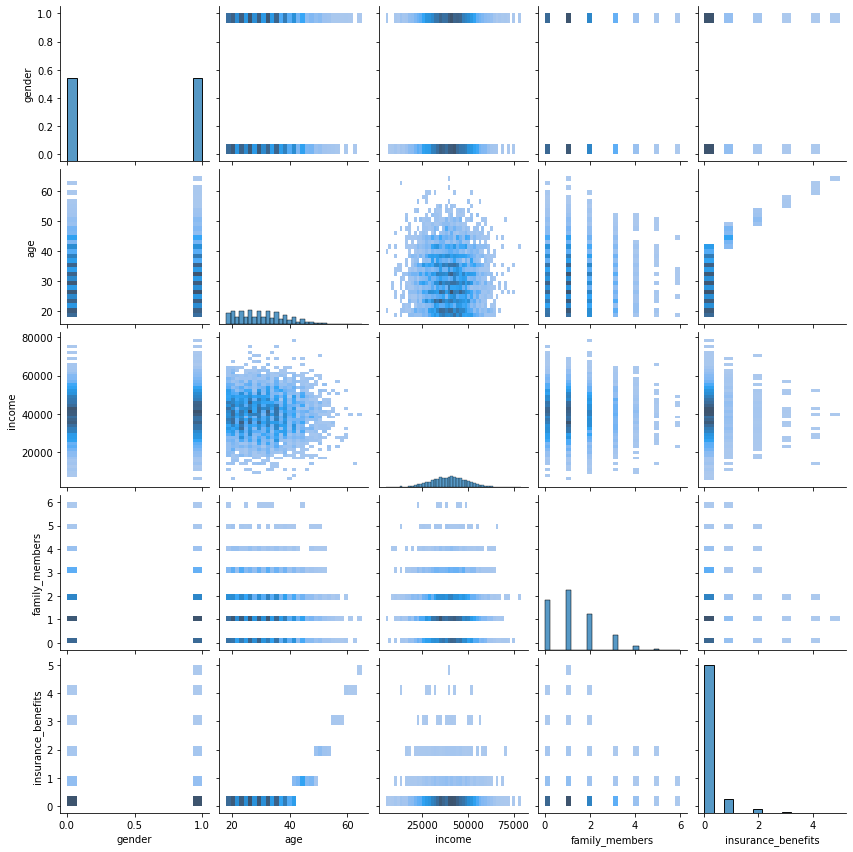

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

## Conclusion (EDA)
It is difficult to spot obvious groups (clusters) because it is difficult to combine several variables simultaneously (to analyze multivariate distributions).

# Task 1:  Similar Customers
In this section, we will write a function that uses the k-nearest neighbor algorithm to identify the nearest neighbors for a given record.  We will explore the effects of two distance metrics (Euclidian and Manhattan) and two scaling approaches (unscaled and scaling by maximum absolute value).

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(metric=metric)
    nbrs.fit(df.values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']
scaler = MaxAbsScaler().fit(df[feature_names].to_numpy())
df_scaled = df.copy()
df_scaled.loc[:, feature_names] = scaler.transform(df[feature_names].to_numpy())

In [14]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2782,1.0,0.384615,0.544304,0.166667,0
4254,0.0,0.507692,0.318987,0.333333,0
1487,0.0,0.584615,0.397468,0.166667,0
2042,0.0,0.615385,0.369620,0.333333,0
1722,0.0,0.446154,0.329114,0.500000,0


We will randomly select a row and find the 5 nearest neighbors using all four combinations of scaled/unscaled and Euclidean/Manhattan.

In [15]:
k = 5
random_row = df.sample(1)
n = random_row.index[0]
random_row

,gender,age,income,family_members,insurance_benefits
583,0,21,57100.0,1,0


In [16]:
# Unscaled, Euclidean
metric = 'euclidean'
get_knn(df[feature_names], n, k, metric)

,gender,age,income,family_members,distance
583,0,21,57100.0,1,0.000000
2424,1,18,57100.0,1,3.162278
4510,0,26,57100.0,1,5.000000
3731,1,31,57100.0,2,10.099505
1729,0,35,57100.0,1,14.000000


In [17]:
# Scaled, Euclidean
get_knn(df_scaled[feature_names], n, k, metric)

,gender,age,income,family_members,distance
583,0.0,0.323077,0.722785,0.166667,0.000000
4990,0.0,0.338462,0.718987,0.166667,0.015846
2683,0.0,0.323077,0.739241,0.166667,0.016456
1289,0.0,0.323077,0.693671,0.166667,0.029114
1448,0.0,0.307692,0.694937,0.166667,0.031815


In [18]:
# Unscaled, Manhattan
metric = 'manhattan'
get_knn(df[feature_names], n, k, metric)

,gender,age,income,family_members,distance
583,0,21,57100.0,1,0.0
2424,1,18,57100.0,1,4.0
4510,0,26,57100.0,1,5.0
3731,1,31,57100.0,2,12.0
1729,0,35,57100.0,1,14.0


In [19]:
# Scaled, Manhattan
get_knn(df_scaled[feature_names], n, k, metric)

,gender,age,income,family_members,distance
583,0.0,0.323077,0.722785,0.166667,0.000000
2683,0.0,0.323077,0.739241,0.166667,0.016456
4990,0.0,0.338462,0.718987,0.166667,0.019182
1289,0.0,0.323077,0.693671,0.166667,0.029114
4899,0.0,0.323077,0.758228,0.166667,0.035443


## Conclusion (task 1)

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Scaling does affect the kNN algorithm.  Without scaling, the feature with the largest magnitude dominates.  In the example above, <code>income</code> has the highest magnitude, and without scaling, the algorithm chooses records where the <code>income</code> is an exact match.  Features with smaller magnitudes are, in effect, ignored.  When the features are scaled, the algorithm does not require an exact income match, and features with smaller magnitudes, such as age, influence the result.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Using the Manhattan distance metric yields similar, but not identical, results to the Euclidean distance metric.  For some randomly selected rows, the top 5 neighbors are the same with both distance metrics.  For other rows, there are differences.  In practice, the best distance metric could be determined by trying several distance metrics and choosing the one that yields the best quality metrics.

# Task 2:  Is Customer Likely to Receive Insurance Benefit?

In [20]:
# Calculate the target: Convert benefit count to 1 or 0
df['insurance_benefits_received'] = np.sign(df['insurance_benefits'])

# Check for class imbalance
df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

Our classes are unbalanced.  Most customers did not receive benefits.  Later, we will see whether balancing the classes affects the result.

In [21]:
def eval_classifier(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    print(f'F1: {f1:.2f}')
    
    cm = confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

## Dummy model

In [22]:
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    print(f'The probability: {P:.2f}')
    size = len(df['insurance_benefits_received'])
    y_pred_rnd = rnd_model_predict(P, size, seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



We can see how our random model performs for various probabilities of customers receiving benefits.  In our dataset, the probability of a customer receiving benefits is 0.11, and the random model based on this probability has an f1 score of 0.12.

## kNN model

In [24]:
# We found slightly better results when the kNN classifier weights
# the votes based on distance.
WEIGHTS = 'distance'

### Unscaled features

In [25]:
y = df['insurance_benefits_received']
X = df.drop('insurance_benefits_received', axis=1).drop('insurance_benefits', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE)

In [26]:
X_train.head()

,gender,age,income,family_members
308,1,25,44600.0,1
3147,1,23,52300.0,3
4698,1,29,45600.0,1
805,0,30,21600.0,1
2512,1,19,43200.0,1


In [27]:
for k in range (1, 11):
    print("k = " + str(k))
    neigh = KNeighborsClassifier(n_neighbors=k, weights=WEIGHTS)
    neigh.fit(X_train, y_train)
    y_hat = neigh.predict(X_test)
    eval_classifier(y_test, y_hat)
    print()

k = 1
F1: 0.59
Confusion Matrix
[[0.86933333 0.02266667]
 [0.05266667 0.05533333]]

k = 2
F1: 0.60
Confusion Matrix
[[0.87133333 0.02066667]
 [0.05266667 0.05533333]]

k = 3
F1: 0.55
Confusion Matrix
[[0.874      0.018     ]
 [0.06066667 0.04733333]]

k = 4
F1: 0.52
Confusion Matrix
[[0.87533333 0.01666667]
 [0.06466667 0.04333333]]

k = 5
F1: 0.50
Confusion Matrix
[[0.878      0.014     ]
 [0.06733333 0.04066667]]

k = 6
F1: 0.46
Confusion Matrix
[[0.87866667 0.01333333]
 [0.07133333 0.03666667]]

k = 7
F1: 0.45
Confusion Matrix
[[0.87866667 0.01333333]
 [0.07266667 0.03533333]]

k = 8
F1: 0.43
Confusion Matrix
[[0.87933333 0.01266667]
 [0.07533333 0.03266667]]

k = 9
F1: 0.40
Confusion Matrix
[[0.87933333 0.01266667]
 [0.078      0.03      ]]

k = 10
F1: 0.40
Confusion Matrix
[[0.88066667 0.01133333]
 [0.078      0.03      ]]



Without feature scaling, the kNN algorithm achieves an maximum f1 score of 0.60, using 2 neighbors, weighted by distance.  This is a significant improvement over the dummy model.

### Scaled features

In [28]:
scaler = MaxAbsScaler().fit(X_train.to_numpy())

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled.loc[:, X_train.columns] = scaler.transform(X_train.to_numpy())
X_test_scaled.loc[:, X_test.columns] = scaler.transform(X_test_scaled.to_numpy())

In [29]:
X_train_scaled.sample(5)

,gender,age,income,family_members
4229,0.0,0.507692,0.434177,0.000000
1755,0.0,0.476923,0.532911,0.000000
4981,1.0,0.400000,0.503797,0.000000
2826,0.0,0.492308,0.616456,0.333333
4477,0.0,0.692308,0.459494,0.166667


In [30]:
for k in range (1, 11):
    print("k = " + str(k))
    neigh = KNeighborsClassifier(n_neighbors=k, weights=WEIGHTS)
    neigh.fit(X_train_scaled, y_train)
    y_hat = neigh.predict(X_test_scaled)
    eval_classifier(y_test, y_hat)
    print()

k = 1
F1: 0.95
Confusion Matrix
[[0.88933333 0.00266667]
 [0.00866667 0.09933333]]

k = 2
F1: 0.95
Confusion Matrix
[[0.88933333 0.00266667]
 [0.00866667 0.09933333]]

k = 3
F1: 0.94
Confusion Matrix
[[0.88866667 0.00333333]
 [0.00933333 0.09866667]]

k = 4
F1: 0.94
Confusion Matrix
[[0.88866667 0.00333333]
 [0.00933333 0.09866667]]

k = 5
F1: 0.94
Confusion Matrix
[[0.88933333 0.00266667]
 [0.01       0.098     ]]

k = 6
F1: 0.93
Confusion Matrix
[[0.88866667 0.00333333]
 [0.01066667 0.09733333]]

k = 7
F1: 0.93
Confusion Matrix
[[0.88933333 0.00266667]
 [0.012      0.096     ]]

k = 8
F1: 0.93
Confusion Matrix
[[0.88933333 0.00266667]
 [0.012      0.096     ]]

k = 9
F1: 0.94
Confusion Matrix
[[0.89       0.002     ]
 [0.01133333 0.09666667]]

k = 10
F1: 0.94
Confusion Matrix
[[0.89066667 0.00133333]
 [0.012      0.096     ]]



Feature scaling drastically improved performance of the model, with a maximum f1 score of 0.95 using 1 or 2 neighbors.  The the model also performs well with other near-neighbors are given a vote.

### Balanced data
Next we will upsample to eliminate class imbalance and see whether this improves model performance.

In [31]:
# Upsample to eliminate class imbalance
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_scaled, y_train)

In [32]:
y_train_balanced.value_counts()

0    3098
1    3098
Name: insurance_benefits_received, dtype: int64

In [33]:
for k in range (1, 11):
    print("k = " + str(k))
    neigh = KNeighborsClassifier(n_neighbors=k, weights=WEIGHTS)
    neigh.fit(X_train_balanced, y_train_balanced)
    y_hat = neigh.predict(X_test_scaled)
    eval_classifier(y_test, y_hat)
    print()

k = 1
F1: 0.95
Confusion Matrix
[[0.88933333 0.00266667]
 [0.00866667 0.09933333]]

k = 2
F1: 0.95
Confusion Matrix
[[0.88933333 0.00266667]
 [0.00866667 0.09933333]]

k = 3
F1: 0.95
Confusion Matrix
[[0.88533333 0.00666667]
 [0.004      0.104     ]]

k = 4
F1: 0.95
Confusion Matrix
[[0.88533333 0.00666667]
 [0.004      0.104     ]]

k = 5
F1: 0.94
Confusion Matrix
[[0.88133333 0.01066667]
 [0.00266667 0.10533333]]

k = 6
F1: 0.92
Confusion Matrix
[[0.87733333 0.01466667]
 [0.00266667 0.10533333]]

k = 7
F1: 0.91
Confusion Matrix
[[0.87333333 0.01866667]
 [0.002      0.106     ]]

k = 8
F1: 0.91
Confusion Matrix
[[0.872      0.02      ]
 [0.00133333 0.10666667]]

k = 9
F1: 0.91
Confusion Matrix
[[8.72666667e-01 1.93333333e-02]
 [6.66666667e-04 1.07333333e-01]]

k = 10
F1: 0.91
Confusion Matrix
[[0.872      0.02      ]
 [0.00133333 0.10666667]]



Upsampling yielded a slight improvement when 3 or 4 neighbors are granted a vote.

## Conclusion (task 2)

In this section, we developed a kNN model to predict whether a customer will receive insurance benefits.  We found that:

- kNN outperformed the dummy model by a wide margin.
- Increasing the number of neighbors beyond 1 did not improve performance, but with scaled data and class balancing, up to 4 neighbors can be used without harming performance.
- Feature scaling dramatically improved model performance.
- Class balancing showed a small performance benefit when 3 or 4 neighbors were used for classification.

# Task 3:  Regression
In this section, we will develop a Python class that implements linear regression "from scratch".  Using the training data, the class will find the regression coefficients that minimize mean-squared error.  Then, using the test data, the class will predict predict `insurance_benefits`.

In [34]:
class MyLinearRegression:
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = ((np.linalg.inv(X2.T@X2))@X2.T)@y

    def predict(self, X):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2@self.weights
        
        return y_pred

We will use the root mean squared error to evaluate the model.

In [35]:
def eval_regressor(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)**0.5
    print(f'RMSE: {rmse:.2f}')
    
    r2 = r2_score(y_true, y_pred)**0.5
    print(f'R2: {r2:.2f}')    

We split the whole data in the 70:30 proportion for the training/validation. 

In [36]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12345)

In [37]:
lr = MyLinearRegression()

lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.34
R2: 0.66


In [38]:
# The array slice omits the intercept term for easier comparison with sklearn result.
print(f'Coefficients: {lr.weights[1:]}')

Coefficients: [ 3.57495491e-02  1.64272726e-02 -2.60743659e-07 -1.16902127e-02]


We can easily compare the results of our custom linear regression class with results from *sklearn*.

In [39]:
sk_lr = LinearRegression().fit(X_train, y_train)
y_test_pred = sk_lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.34
R2: 0.66


In [40]:
print(f'Coefficients: {sk_lr.coef_}')

Coefficients: [ 3.57495491e-02  1.64272726e-02 -2.60743659e-07 -1.16902127e-02]


## Conclusion (task 3)

Our custom linear regression implementation appears to be correct, as it produces the same performance metrics and regression coefficients as the version in *sklearn*.

# Task 4. Obfuscating Data
In this section, we will demonstrate the feasibility of data obfuscation for linear regression.  To obfuscate customers' personal information, we will multiply the feature matrix by an invertible matrix of random numbers.  The resulting data will not be interpretable, but the original features can be restored by multiplying the obfuscated feature matrix by the inverse of the random number matrix.  We will also prove analytically and demonstrate empirically that obfuscation does not affect the results of linear regression.

In [41]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [42]:
X = df_pn.to_numpy()

Generate a random matrix $P$.

In [43]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Confirm that the matrix $P$ is invertible

In [44]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

To obfuscate the the feature matrix, multiply it by $P$.

In [45]:
X_obfuscated = X@P
pd.DataFrame(X_obfuscated, columns=personal_info_column_list).head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


It is not possible to guess the customers' ages or income after the transformation. 

To recover the original data, multiply the obfuscated data by $P^{-1}$.

In [46]:
X_recovered = X_obfuscated@np.linalg.inv(P)
pd.DataFrame(X_recovered, columns=personal_info_column_list).head()

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-3.183231e-12,46.0,38000.0,1.000000e+00
2,1.364242e-12,29.0,21000.0,0.000000e+00
3,-3.637979e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,3.637979e-12


Show the obfuscated and recovered data for a few randomly selected records.

In [47]:
examples = df_pn.sample(3)
print('Original:')
examples

Original:


,gender,age,income,family_members
2674,1,28,46200.0,0
3503,0,23,27600.0,0
3434,1,36,41000.0,2


In [48]:
print('Obfuscated:')
pd.DataFrame(examples.to_numpy()@P, columns=personal_info_column_list)

Obfuscated:


,gender,age,income,family_members
0,5922.260751,20835.586635,17153.039229,42839.249653
1,3538.102341,12453.091200,10251.531682,25596.793171
2,5258.111011,18503.030260,15231.865449,38026.814703


In [49]:
print('Recovered:')
pd.DataFrame((examples.to_numpy()@P)@np.linalg.inv(P), columns=personal_info_column_list)

Recovered:


,gender,age,income,family_members
0,1.000000e+00,28.0,46200.0,3.637979e-12
1,-4.547474e-13,23.0,27600.0,2.728484e-12
2,1.000000e+00,36.0,41000.0,2.000000e+00


The method works.  The restored features match the original features, but some of the restored features look a little different because matrix multiplication converts integer values to floating point.

## Proof That Data Obfuscation Can Work with LR
In this section we will prove analytically that our obfuscation method won't affect the predictions of our linear regression model.  We will show how the regression coefficients for the obfuscated features are related to the regression coeffificents for the original features through the random number matrix $P$.

Our custom linear regression class used the following matrix equation to find the weights that minimize mean squared error:

$$
w = (X^T X)^{-1} X^T y
$$

Our obfuscation method substitutes $X^{'} = X \times P$ for $X$, so the equation for our obfuscated weight vector is

$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How are the original weight vector $w$ and the obfuscated weight vector $w_P$ related?

**Answer**

The obfuscated weight vector $w_P$ is a simple transformation of the original weight vector $w$:

$$
w_P = P^{-1} w
$$

**Analytical proof**

|   |   |
|---|---|
| $$ w_P = [(XP)^T XP]^{-1} (XP)^T y $$ 	| Given 	|
| $$ = [(P^{T}X^{T}X)P]^{-1} (XP)^T y $$ 	| Reversivity of the transpose of a product of matrices, <br/>regrouping (associative property of multiplication) 	|
| $$ = P^{-1}[P^{T}(X^{T}X)]^{-1} (XP)^T y $$ 	| Multiplicative identity property, regrouping 	|
| $$ = P^{-1} (X^{T}X)^{-1} (P^{T})^{-1} (XP)^T y $$ 	| Multiplicative identity property 	|
| $$ = P^{-1} (X^{T}X)^{-1} (P^{T})^{-1} P^{T} X^{T} y $$ 	| Reversivity... 	|
| $$ = P^{-1} (X^{T}X)^{-1} X^{T} y $$ 	| Identity matrix 	|
| $$ = P^{-1} w $$ 	| Substituting $w$ 	|

## Test Linear Regression With Data Obfuscation
In this section, we will modify our custom linear regression class to support obfuscation, and we will compare the results using obfuscated data to the results without obfuscation.

In [50]:
class ObfuscatableLR():
    def __init__(self, mask=None):
        self.weights = None
        self.mask = mask

    def fit(self, X, y):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        if type(self.mask) is np.ndarray:
            X2 = X2@self.mask
        self.weights = ((np.linalg.inv(X2.T@X2))@X2.T)@y

    def get_weights(self):
        return self.weights

    def predict(self, X):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        if type(self.mask) is np.ndarray:
            X2 = X2@self.mask
        y_pred = X2@self.weights
        
        return y_pred

In [51]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE)

First, we will test the class without obfuscation.

In [52]:
lr = ObfuscatableLR()
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.33
R2: 0.64


In [53]:
w = lr.weights
print(f'Coefficients: {w}')

Coefficients: [-9.59392098e-01  3.65344879e-02  8.18179629e-03 -2.19473247e-07
 -1.46482430e-02]


Next, we will test the class with obfuscation.

Create a square matrix $P$ of random numbers and verify that it is invertible.

In [54]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1]+1, X.shape[1]+1))
np.linalg.inv(P)

array([[ 1.41035943,  0.90610582, -2.00787937,  1.47271069, -0.74623617],
       [-0.28558107,  0.49848661,  1.15086093,  0.0066473 , -0.91487427],
       [-0.69970518, -0.42288786,  1.45986829, -2.04553524,  1.15768716],
       [ 1.13604007, -0.85209178, -0.28484747,  0.86319324, -0.18263762],
       [-1.6744307 ,  0.39554207, -0.06237199,  0.12315311,  1.19402846]])

In [55]:
lr = ObfuscatableLR(mask=P)
lr.fit(X_train, y_train)
y_test_pred_obs = lr.predict(X_test)
eval_regressor(y_test, y_test_pred_obs)

RMSE: 0.33
R2: 0.64


The quality metrics for the obfuscated data match the metrics without obfuscation.

In [56]:
w_P = lr.weights
print(f'Coefficients: {w_P}')

Coefficients: [-1.32541534  0.31499694  0.65079232 -1.12064844  1.60282067]


As expected, the weights are different, but we should be able to recover the original weights using the equation from our proof.

In [57]:
w = P@w_P
w

array([-9.59353909e-01,  3.65340101e-02,  8.17615272e-03, -2.19956428e-07,
       -1.46493343e-02])

We were able to recover the original weight vector $w$ by multiplying the random matrix $P$ by obfuscated weight vector $w_P$.

## Conclusion (task 4)
In this section we worked with data obfuscation for linear regression.
- We showed that the feature matrix can be obfuscated by multiplying it by an invertible square matrix of random numbers, and the original features can be restored by multiplying by inverse of the random number matrix.
- We found an analytic relationship bewteen the weight vector of original data and the weight vector of the obfuscated data.
- We implemented a linear regression class to demonstrate our findings computationally.  The quality metrics were the same with and without obfuscation, and we showed that we can convert between obfuscated/original weights using the random number matrix.

# Conclusions
We performed several machine learning tasks the the Sure Tomorrow insurance company.
- We used the k-nearest neighbor algorithm to identify customers similar to a given customer.  We examined the effects of two distance metrics (Euclidian and Manhattan) and two scaling approaches (unscaled and scaling by maximum absolute value).  We found that feature scaling has a significant effect on the results of the k-nearest neighbor algorithm.  We also found some differences in results based on the distance metric.
- We used the k-nearest neighbor classifier to predict whether a customer will receive an insurance benefit.  The kNN classifier performed much better than a dummy model.  Feature scaling dramatically improved model performance.  Class balancing showed a small improvement for some *k* values.
- We developed a "from scratch" linear regression model to predict the number of insurance benefits a customer is likely to receive and found that it gave the same results as the model in the *sklearn* library.
- We worked with data obfuscation.  We derived a simple relationship between linear regression models with and without obfuscation, and we demonstrated the equivalance of the models computationally.